# Imports

In [2]:
import os
import string
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
import seaborn

from preprocessing import Preprocessor
from data_loader import DataLoader
from helpers import select_n_components, pos_check
from textblob import TextBlob
from tqdm import tqdm
from itertools import permutations

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
import umap

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gtvfv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [3]:
train, validate, test = DataLoader().create_dataframe(preprocess=True, split=True, remove_duplicates=True)

100%|███████████████████████████████████████████████████████████████████████| 239073/239073 [00:16<00:00, 14674.20it/s]


In [4]:
train.head()

,phrase_id,phrase,phrase_clean,sentiment_val,label_id,label
64633,3748,a fairy tale that comes from a renowned indian...,fairy tale comes renowned indian film culture ...,0.88889,5.0,Very positive
23483,183087,Chris Cooper 's,Chris Cooper,0.50000,3.0,Neutral
93051,229624,call it a work of art,call work art,0.76389,4.0,Positive
15507,103745,A muddled limp biscuit,A muddled limp biscuit,0.19444,1.0,Very negative
84727,115229,ate,ate,0.36111,2.0,Negative


# Train, test, dev

In [5]:
X_train, y_train = train['phrase_clean'], train['label_id']
X_val, y_val = validate['phrase_clean'], validate['label_id']
X_test, y_test = test['phrase_clean'], test['label_id']

datasets = [X_train, X_val, X_test]
labels = [y_train, y_val, y_test]

**Transforming text to tf-idf vectors**

In [ ]:
tfidf_vec_length = 2500
vec_length = tfidf_vec_length

In [ ]:
tf_datasets = []

for d in datasets:
    tfidf_vec = TfidfVectorizer(analyzer='word', max_features=tfidf_vec_length, use_idf=True, ngram_range=(1,3))
    tf_datasets.append(tfidf_vec.fit_transform(d).toarray())

In [ ]:
tf_dataset_arrays = []
for d in tf_datasets:
    tf_dataset_arrays.append(np.asarray(d))

In [ ]:
embeddings = []

# Neural network

**Train or load**

In [ ]:
print("started")
lr_init = 1e-3
l2_penalty = 1e-2
embed_size = 2
batch_size = 'auto'
n_iter_no_change = 3
tol = 1e-6
max_iter = 25

nnets = []
sizes = []

while embed_size < vec_length:
    log_vec_l, log_embed_l = math.log2(vec_length), math.log2(embed_size)
    log_hid_l = (log_vec_l + log_embed_l) / 2
    hid_l = int(math.pow(2, log_hid_l))
    hid = (hid_l, embed_size, hid_l)
    
    # auto-encoder
    regressor = MLPRegressor(hidden_layer_sizes=hid, activation='relu', learning_rate='adaptive', random_state=420, 
                             verbose=True, batch_size=batch_size, alpha=l2_penalty, n_iter_no_change=n_iter_no_change, 
                             learning_rate_init=lr_init, tol=tol, max_iter=max_iter)
    filename = 'autoencoder' + str(hid) + '.sav'
    
    if os.path.exists(filename):
        nnet = pickle.load(open(filename, 'rb'))
        print("Loaded " + str(hid))
    else:
        # Fit only on datasets[0], which is training data
        print("Fitting " + str(hid))
        nnet = regressor.fit(tf_datasets[0], tf_datasets[0])
        pickle.dump(nnet, open(filename, 'wb'))
        print("Done fitting.")
    
    nnets.append(nnet)
    sizes.append(hid)
    embed_size *= 2

**Compute embeddings**

In [ ]:
embeddings_nnet = []
embedding_layer_num = 3

for d in tf_dataset_arrays:
    embeddings_dataset = []
    for i, n in enumerate(sizes):
        embed_size = n[1]

        nnet = nnets[i]

        hidden_layer_sizes = list(n)
        layer_units = [tfidf_vec_length] + hidden_layer_sizes + [tfidf_vec_length]

        print("Computing embeddings for nnet " + str(layer_units))
        activations = [d]
        for i in range(nnet.n_layers_ - 1):
            activations.append(np.empty((d.shape[0], layer_units[i + 1])))
        nnet._forward_pass(activations)
        embeddings_dataset.append(activations[embedding_layer_num - 1])
    embeddings_nnet.append(embeddings_dataset)
embeddings.append(embeddings_nnet)
print("Embeddings computed.")

# UMAP

In [10]:
umap_train_size = 20000
scs_dataset_size = 10000
acs_dataset_size = 20000
supervised_dp_size = 200

**Compute embeddings**

In [ ]:
embeddings_umap = []

d = np.concatenate([tf_dataset_arrays[0][0:umap_train_size], tf_dataset_arrays[1][0:supervised_dp_size], tf_dataset_arrays[2][0:acs_dataset_size]],
                   axis=0) 
print(d.shape)

embeddings_dataset_train = []
embeddings_dataset_val = []
embeddings_dataset_test = []


for j, n in enumerate(sizes): 
    embed_size = n[1] # same embedding sizes as in neural net

    umap_reducer = umap.UMAP(n_components=embed_size, random_state=420)

    print("Computing embeddings for umap " + str(embed_size))

    embedding = umap_reducer.fit_transform(d)
    
    embeddings_dataset_train.append(embedding[0:umap_train_size])
    embeddings_dataset_val.append(embedding[umap_train_size:umap_train_size+supervised_dp_size])
    embeddings_dataset_test.append(embedding[umap_train_size+supervised_dp_size::])
        
    
embeddings.append([embeddings_dataset_train, embeddings_dataset_val, embeddings_dataset_test])

print("Embeddings computed.")

In [ ]:
for i, e in enumerate(embeddings):
    for j, d in enumerate(e):
        d.append(tf_dataset_arrays[j])

In [ ]:
for i, e in enumerate(embeddings):
    for j, d in enumerate(embeddings[i]):
        for k, s in enumerate(embeddings[i][j]):
            name = "embeddings_" + str(i) + "_" + str(j) + "_" + str(k)
            np.save(name, embeddings[i][j][k])

# Unsupervised Models

In [6]:
k_means = []
scs = []
acs = []

clusters = 5

i_ = 2
j_ = 12

for i in range(i_):
    k_means_e = []
    scs_e = []
    acs_e = []
    for j in range(j_): #(embeddings[i][0]):
        d = np.load("embeddings_" + str(i) + "_" + str(0) + "_" + str(j) + ".npy")
        print("Kmeans with " + str(clusters) + " clusters and " + str(d.shape[1]) + " sized embeddings.")
        kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init=1, max_iter=100, random_state=420)
        k_means_e.append(kmeans.fit(d))

        print("SpectralClustering with " + str(clusters) + " clusters and " + str(d.shape[1]) + " sized embeddings.")
        sc = SpectralClustering(n_clusters=clusters)
        #scs.append(sc.fit(d[::scs_dataset_size]))
        scs_e.append(sc)

        print("AgglomerativeClustering with " + str(clusters) + " clusters and " + str(d.shape[1]) + " sized embeddings.")
        ac = AgglomerativeClustering(n_clusters=clusters)
        #acs.append(ac.fit(d[::acs_dataset_size]))
        acs_e.append(ac)
    k_means.append(k_means_e)
    scs.append(scs_e)
    acs.append(acs_e)

Kmeans with 5 clusters and 2 sized embeddings.
SpectralClustering with 5 clusters and 2 sized embeddings.
AgglomerativeClustering with 5 clusters and 2 sized embeddings.
Kmeans with 5 clusters and 4 sized embeddings.
SpectralClustering with 5 clusters and 4 sized embeddings.
AgglomerativeClustering with 5 clusters and 4 sized embeddings.
Kmeans with 5 clusters and 8 sized embeddings.
SpectralClustering with 5 clusters and 8 sized embeddings.
AgglomerativeClustering with 5 clusters and 8 sized embeddings.
Kmeans with 5 clusters and 16 sized embeddings.
SpectralClustering with 5 clusters and 16 sized embeddings.
AgglomerativeClustering with 5 clusters and 16 sized embeddings.
Kmeans with 5 clusters and 32 sized embeddings.
SpectralClustering with 5 clusters and 32 sized embeddings.
AgglomerativeClustering with 5 clusters and 32 sized embeddings.
Kmeans with 5 clusters and 64 sized embeddings.
SpectralClustering with 5 clusters and 64 sized embeddings.
AgglomerativeClustering with 5 clust

**Create mappings from clusters to labels**

In [19]:
def label_map(pred, gt, clusters):
    labels = list(range(1, clusters+1))
    argmax_map = labels
    max_map = 0
    for p in permutations(labels, clusters):
        match_count = 0
        for i in range(pred.shape[0]):
            if p.index(pred[i]+1) == labels.index(int(gt[i])):
                match_count+=1
        if match_count > max_map:
            argmax_map = p
            max_map = match_count
    return argmax_map

def map_labels(pred, label_map):
    for i in range(pred.shape[0]):
        pred[i] = label_map.index(pred[i]+1)+1
    return pred

In [20]:
def test_metrics(y_val, preds):
    preds = preds.astype(int)
    accuracy = accuracy_score(y_val, preds)
    precision = precision_score(y_val, preds, average='macro')
    recall = recall_score(y_val, preds, average='macro')
    f1 = f1_score(y_val, preds, average='macro')
    kappa = cohen_kappa_score(y_val, preds)
    return [accuracy, precision, recall, f1, kappa]

**Compute all predictions**

In [22]:
y_val_sub_set = labels[1][0:supervised_dp_size].to_numpy().astype(int)
y_test_set = labels[2]

k_means_metrics = []
sc_metrics = []
ac_metrics = []
kmeans_map = []

i_ = 2
j_ = 1#j_ = 12

# Validation set
for i in range(i_):
    for j in range(j_):
        print(j)
        x_train_set = np.load("embeddings_" + str(i) + "_" + str(0) + "_" + str(j) + ".npy") #embeddings[i][0][j]
        x_test_set = np.load("embeddings_" + str(i) + "_" + str(2) + "_" + str(j) + ".npy")
        x_val_sub_set = np.load("embeddings_" + str(i) + "_" + str(1) + "_" + str(j) + ".npy")[0:supervised_dp_size]

        # kmeans predictions on val and test set
        k_means_pred_set = np.concatenate([x_val_sub_set, x_test_set], axis=0)
        k_means_pred = k_means[i][j].predict(k_means_pred_set)
        k_means_pred_val = k_means_pred[0:supervised_dp_size]
        k_means_map = label_map(k_means_pred_val, y_val_sub_set, clusters)
        kmeans_map.append(k_means_map) 
        k_means_pred_test = map_labels(k_means_pred[supervised_dp_size::], k_means_map)
        k_means_metric = test_metrics(y_test_set[0:len(k_means_pred_test)].to_numpy().astype(int), k_means_pred_test)
        k_means_metrics.append(k_means_metrics)
        print(k_means_metric)

        '''
        # sc and ac computations and predictions on val and test sets
        sc_pred_set = np.concatenate([x_val_sub_set, x_test_set[0:scs_dataset_size]], axis=0)
        sc_pred = scs[i][j].fit_predict(sc_pred_set)
        sc_pred_val = sc_pred[0:supervised_dp_size]
        sc_map = label_map(sc_pred_val, y_val_sub_set, clusters)
        sc_pred_test = map_labels(sc_pred[supervised_dp_size:scs_dataset_size + supervised_dp_size], sc_map)
        sc_metric = test_metrics(y_test_set[0:scs_dataset_size].to_numpy().astype(int), sc_pred_test)
        sc_metrics.append(sc_metrics)
        print(sc_metric)

        ac_pred_set = np.concatenate([x_val_sub_set, x_test_set[0:acs_dataset_size]], axis=0)
        print(ac_pred_set.shape)
        ac_pred = acs[i][j].fit_predict(ac_pred_set)
        ac_pred_val = ac_pred[0:supervised_dp_size]
        ac_map = label_map(ac_pred_val, y_val_sub_set, clusters)
        ac_pred_test = map_labels(ac_pred[supervised_dp_size:acs_dataset_size + supervised_dp_size], ac_map)
        ac_metric = test_metrics(y_test_set[0:acs_dataset_size].to_numpy().astype(int), ac_pred_test)
        ac_metrics.append(ac_metric)
        print(ac_metric)'''

0
[0.49195281230250687, 0.20685306076636972, 0.2014907588343128, 0.13715645877987015, 0.0022928586756458813]
0
[0.4068, 0.19971716241163373, 0.19802040755999667, 0.17906826419238744, -5.149034498286298e-05]


In [ ]:
nnet_metrics = k_means_metrics[0:12]
print(len(nnet_metrics))
plt.plot( k_means_metrics[0])
plt.show()

[[0.63727821 0.59847327]
 [1.12391088 0.82544687]
 [0.89596021 1.59429641]
 [0.81278233 0.36559441]
 [0.40687849 0.90011296]]
(2, 3, 1, 4, 5)


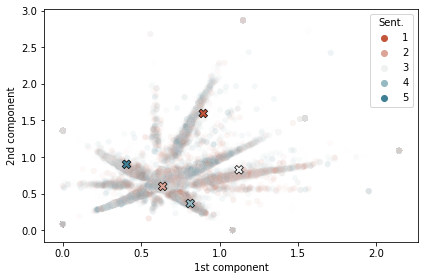

In [46]:
fig, axs = plt.subplots()

nnet = np.load("embeddings_" + str(0) + "_" + str(0) + "_" + str(0) + ".npy")
centers = k_means[0][0].cluster_centers_
print(centers)
print(kmeans_map[0])

df_x = pd.DataFrame(nnet)
df_y = pd.DataFrame(np.expand_dims(np.array(labels[0], dtype='int'), axis=1))
df = pd.concat([df_x, df_y], axis=1)
df.columns = ["1st component", "2nd component", "Sent."]
seaborn.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue=df.columns[2], 
                    palette=seaborn.diverging_palette(20, 220, as_cmap=True), alpha=0.05, legend=False, ax=axs)
df_x = pd.DataFrame(centers)
df_y = pd.DataFrame(np.expand_dims(np.array(kmeans_map[0], dtype='int'), axis=1))
df = pd.concat([df_x, df_y], axis=1)
df.columns = ["1st component", "2nd component", "Sent."]
seaborn.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue=df.columns[2], 
                    palette=seaborn.diverging_palette(20, 220, as_cmap=True), marker='X', s=75, edgecolor='black', ax=axs)
fig.tight_layout() 


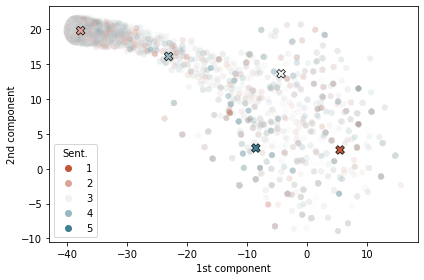

In [48]:
fig, axs = plt.subplots()

umap = np.load("embeddings_" + str(1) + "_" + str(0) + "_" + str(0) + ".npy")
centers = k_means[1][0].cluster_centers_

df_x = pd.DataFrame(umap)
df_y = pd.DataFrame(np.expand_dims(np.array(labels[0], dtype='int'), axis=1))
df = pd.concat([df_x, df_y], axis=1)
df.columns = ["1st component", "2nd component", "Sent."]
seaborn.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue=df.columns[2], 
                    palette=seaborn.diverging_palette(20, 220, as_cmap=True), legend=False, alpha=0.05)

df_x = pd.DataFrame(centers)
df_y = pd.DataFrame(np.expand_dims(np.array(kmeans_map[1], dtype='int'), axis=1))
df = pd.concat([df_x, df_y], axis=1)
df.columns = ["1st component", "2nd component", "Sent."]
seaborn.scatterplot(data=df, x=df.columns[0], y=df.columns[1], hue=df.columns[2], 
                    palette=seaborn.diverging_palette(20, 220, as_cmap=True), marker='X', s=75, edgecolor='black', ax=axs)
fig.tight_layout()